In [367]:
import pygame as pg
import sys
import random
import numpy as np

In [368]:
def obstacle_render(obs_list,obst_list):
    if obs_list:
        for i in range (len(obs_list)):
            screen.blit(pipe,pipe.get_rect(topright=obs_list[i]))
            screen.blit(pipet,pipet.get_rect(topright=obst_list[i]))
            obst_list[i][0]=obst_list[i][0]-4
            obs_list[i][0]=obst_list[i][0]-4
        if obs_list[0][0]<100:
            del obs_list[0]
            del obst_list[0]
        return obs_list,obst_list
    else:
        return[],[]

In [369]:
def create_tile_encoding(state, num_tiles_x=50, num_tiles_y=65, num_tiles_velocity=10):
    # Define the ranges for x, y, and velocity
    x=state[0]
    y=state[1]
    velocity=state[2]
    min_x, max_x = 0, 620
    min_y, max_y = 0, 1000
    min_velocity, max_velocity = 0, 69
    
    # Calculate tile widths for each dimension
    tile_width_x = (max_x - min_x) / num_tiles_x
    tile_width_y = (max_y - min_y) / num_tiles_y
    tile_width_velocity = (max_velocity - min_velocity) / num_tiles_velocity
    
    # Calculate the tile indices for each dimension
    tile_index_x = int((x - min_x) // tile_width_x)
    tile_index_y = int((y - min_y) // tile_width_y)
    tile_index_velocity = int((velocity - min_velocity) // tile_width_velocity)
    
    return [tile_index_x,tile_index_y,tile_index_velocity]

In [370]:
# x = horizontal distance between birdcenter and the pipe right range={0,4,....,604}, 50 tiles
# y = vertical distance of birdcenter and bottom pipe top range=[-300,475], 50 tiles
# z = velocity of the bird range=[-47,21], 10 tiles 
# last one denotes action
Q_value=np.zeros((50,65,10,2))

In [371]:
eps=0.0001
td_error=0.8
Y=0.8

In [372]:
def get_next_state(cur,obs_list):
    nexts=[0,0,0]
    if obs_list[0][0]==100:
        nexts[0]=(obs_list[1][0]-100)/4
        if cur[3]==0:
            nexts[1]=int(obs_list[1][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
            nexts[2]=a-(t+0.5)*2+47
        if cur[3]==1:
            nexts[1]=int(obs_list[1][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
            nexts[2]=21+47
    else:
        nexts[0]=cur[0]-1
        if cur[3]==0:
            nexts[1]=int(obs_list[0][1]-s+(t+0.5)*(t+0.5)-(t+0.5)*a+301)
            nexts[2]=a-(t+0.5)*2+47
        if cur[3]==1:
            nexts[1]=int(obs_list[0][1]-(s+t*t-t*a + 0.5*0.5 -0.5*21)+301)
            nexts[2]=21+47
    for i in range(3):
        nexts[i]=int(nexts[i])
    return nexts

In [373]:

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)

#defining timer for the obstacles to occur
for i in range(1000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,2000)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1200,400]]
    obst_list=[[500,400-680],[900,300-680],[1200,400-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    cur_st[2]=0
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        print(next_state[2],next_state_en[2])
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[3]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=571 or el1.top<=5:
            reward=-300
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward-Y*Q_value[tuple(cur_st_en)])
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=10
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            print(smax)

            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()
        print(next_state[1])
        t=t+0.5
        pg.display.update()
        #clock.tick(60)
        cur_st=[next_state[0],next_state[1],next_state[2]]
    

46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
23 3
445
22 3
457
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
31 4
122
30 4
130
29 4
139
28 4
148
27 3
158
26 3
168
25 3
179
24 3
190
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422

46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
31 4
122
30 4
130
29 4
139
28 4
148
27 3
158
68 9
189
68 9
199
68 9
209
68 9
220
66 9
189
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6


38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
68 9
233
66 9
202
65 9
193
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
66 9
282
68 9
333
66 9
302
65 9
293
64 9
284
68 9
371
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
61 8
299
60 8
292
59 8
286
58 8
280
57 8
275
68 9
456
66 9
426
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7

36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
68 9
233
66 9
202
65 9
193
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
66 9
282
68 9
333
66 9
302
65 9
293
64 9
284
68 9
371
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
61 8
299
60 8
292
68 9
439
66 9
408
68 9
459
66 9
428
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62

66 9
302
65 9
293
64 9
284
68 9
371
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
61 8
299
60 8
292
68 9
439
66 9
408
65 9
399
68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
68 9
233
66 9
202
65 9
193
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
66 9
282
68 9
333
66 9
302
65 9
293
64 9
284
68 9
371
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
61 8
299
60 8
292
68 9
439
66 9
408
65 9
399
68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350

34 4
100
33 4
107
32 4
114
68 9
233
68 9
243
68 9
253
68 9
263
68 9
274
68 9
284
68 9
294
68 9
304
68 9
315
66 9
284
68 9
335
66 9
304
68 9
355
66 9
324
65 9
315
64 9
306
68 9
393
68 9
403
68 9
413
68 9
423
68 9
434
66 9
403
68 9
454
66 9
423
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
68 9
233
66 9
202
65 9
193
68 9
262
68 9
272
68 9
282
68 9
293
66 9
262
68 9
313
66 9
282
68 9
333
66 9
302
65 9
293
64 9
284
68 9
371
66 9
340
65 9
331
64 9
322
63 9
314
62 8
306
68 9
425
68 9
435
66 9
405
68 9
455
66 9
425
46 6
301
45 6
302
44 6
303

66 9
279
65 9
270
68 9
339
68 9
349
68 9
359
66 9
329
65 9
320
68 9
389
68 9
399
68 9
409
66 9
379
65 9
370
64 9
361
63 9
353
62 8
345
61 8
338
60 8
331
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
68 9
269
66 9
238
68 9
289
66 9
258
68 9
309
68 9
319
68 9
329
66 9
299
68 9
349
66 9
319
68 9
369
66 9
339
65 9
330
64 9
321
68 9
407
66 9
377
65 9
368
64 9
359
63 9
351
62 8
343
61 8
336
68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3


60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
68 9
285
68 9
295
68 9
305
68 9
316
68 9
326
66 9
296
68 9
346
66 9
316
68 9
366
66 9
336
65 9
326
64 9
318
68 9
404
66 9
374
68 9
424
68 9
434
68 9
444
68 9
455
66 9
424
68 9
475
66 9
444
68 9
495
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
68 9
285
68 9
295
68 9
305
68 9
316
68 9
326
66 9
296
68 9
346
66 9
316
68 9
366
66 9
336
65 9
326
64 9
318
68 9
404
68 9
414
68 9
424
68 9
435
66 9
404
68 9
455
66 9
424
68 9
475
66 9
444
65 9
435
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307

30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
68 9
285
66 9
255
65 9
245
68 9
314
66 9
284
68 9
334
66 9
304
65 9
295
64 9
286
68 9
372
68 9
382
68 9
393
66 9
362
65 9
353
64 9
344
63 9
336
68 9
439
66 9
409
68 9
459
66 9
429
68 9
479
68 9
489
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
68 9
285
66 9
255
65 9
245
68 9
314
66 9
284
65 9
275
64 9
266
63 9
258
68 9
360
66 9
330
65 9
321
64 9
312
63 9
304

68 9
284
68 9
294
66 9
264
68 9
314
66 9
284
68 9
334
66 9
304
65 9
295
64 9
286
68 9
372
66 9
342
65 9
333
64 9
324
63 9
316
68 9
418
68 9
429
68 9
439
68 9
449
66 9
419
68 9
469
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
39 5
74
38 5
78
37 5
83
36 5
88
35 5
94
34 4
100
33 4
107
32 4
114
68 9
233
68 9
243
68 9
253
68 9
263
68 9
274
68 9
284
68 9
294
66 9
264
68 9
314
66 9
284
68 9
334
66 9
304
65 9
295
64 9
286
68 9
372
66 9
342
65 9
333
64 9
324
63 9
316
62 8
308
61 8
301
60 8
294
59 8
288
58 8
282
57 8
277
56 8
272
55 7
268
54 7
264
53 7
261
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310

28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
68 9
280
68 9
290
68 9
300
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
68 9
399
66 9
369
65 9
359
64 9
351
68 9
437
68 9
447
68 9
457
68 9
468
68 9
478
66 9
448
68 9
498
66 9
468
68 9
518
68 9
528
68 9
538
68 9
549
68 9
559
68 9
569
68 9
579
68 9
590
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
68 9
280
68 9
290
68 9
300
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
68 9
399
66 9
369
65 9
359
64 9
351
68 9
437
68 9
447
68 9
457
68 9
468
66 9
437
68 9
488
68 9
4

56 8
78
55 7
74
54 7
70
53 7
67
68 9
280
68 9
290
68 9
300
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
66 9
358
68 9
409
66 9
378
65 9
369
68 9
438
66 9
408
65 9
398
68 9
467
68 9
477
68 9
488
68 9
498
66 9
468
68 9
518
66 9
488
65 9
478
64 9
470
68 9
556
66 9
526
65 9
516
64 9
508
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
68 9
280
68 9
290
68 9
300
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
68 9
399
68 9
409
66 9
379
65 9
370
64 9
361
68 9
447
68 9
457
68 9
468
66 9
437
65 9
428
64 9
419
63 9
411
62 8
403
68 9
522
66 9
491
65 9
482
64 9
473
68 9
560
66 9
529
65 9
520
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 

56 8
272
55 7
268
54 7
264
53 7
261
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
48 6
153
47 6
152
46 6
153
45 6
153
44 6
155
43 6
156
42 6
159
41 5
161
40 5
165
39 5
168
38 5
173
37 5
177
36 5
183
35 5
188
34 4
195
68 9
341
66 9
311
65 9
301
64 9
293
63 9
284
68 9
387
66 9
357
65 9
348
64 9
339
63 9
331
62 8
323
61 8
316
60 8
309
59 8
303
58 8
297
57 8
292
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
4

63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
48 6
153
68 9
383
66 9
353
65 9
343
64 9
335
63 9
326
62 8
319
61 8
311
60 8
305
59 8
298
58 8
293
57 8
287
68 9
468
66 9
438
65 9
429
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
48 6
153
47 6
152
46 6
153
45 6
153
44 6
155
43 6
156
42 6
159
41 5
161
40 5
165
39 5
168
38 5
173
37 5
177
36 5
183
35 5
188
68 9
347
66 9
317
68 9
367
68 9
377
68 9
388
66 9
357
68 9
408
66 9
377
65 9
368
68 9
437
66 9
407
65 9
397
64 9
3

34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
68 9
353
66 9
323
65 9
313
64 9
305
63 9
296
62 8
289
68 9
407
66 9
377
65 9
367
64 9
359
63 9
350
62 8
343
68 9
461
68 9
471
66 9
441
68 9
491
66 9
461
65 9
452
64 9
443
63 9
435
62 8
427
68 9
545
66 9
515
68 9
565
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
68 9
341
66 9
311
65 9
301
64 9
293
63 9
284
62 8
277
61 8
269
60 8
263
59 8
256
58 8
251
57

35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
48 6
153
68 9
383
66 9
353
65 9
343
64 9
335
63 9
326
62 8
319
61 8
311
60 8
305
59 8
298
58 8
293
57 8
287
56 8
283
55 7
278
54 7
275
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50

68 9
363
68 9
373
66 9
343
68 9
393
66 9
363
68 9
413
66 9
383
65 9
374
64 9
365
68 9
451
66 9
421
65 9
412
64 9
403
63 9
395
62 8
387
61 8
380
60 8
373
59 8
367
58 8
361
57 8
356
56 8
351
55 7
347
54 7
343
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
68 9
353
68 9
363
68 9
373
66 9
343
68 9
393
66 9
363
65 9
354
64 9
345
63 9
337
62 8
329
61 8
322
60 8
315
59 8
309
58 8
303
57 8
298
56 8
293
55 7
289
68 9
488
66 9
457
65 9
448
64 9
439
63 9
431
62 8
423
61 8
416
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
3

58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
68 9
382
68 9
392
68 9
403
66 9
372
68 9
423
66 9
392
68 9
443
66 9
412
68 9
463
66 9
432
65 9
423
68 9
492
66 9
462
65 9
452
64 9
444
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
54 7
70
53 7
67
52 7
64
51 7
62
50 7
60
49 7
59
48 6
58
47 6
58
46 6
58
45 6
59
44 6
60
43 6
62
42 6
64
41 5
67
40 5
70
68 9
277
66 9
246
68 9
297
68 9
307
68 9
317
68 9
327
68 9
338
68 9
348
66 9
318
68 9
368
66 9
338
68 9
388
68 9
398
68 9
408
68 9
419
68 9
429
68 9
439
66 9
409
68 9
459
68 9
469
46 6
301
45 6
302
44 6
303
43 6
305
42 6
30

26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
68 9
259
68 9
269
66 9
239
68 9
289
68 9
299
66 9
269
65 9
260
64 9
251
63 9
243
62 8
235
61 8
228
60 8
221
59 8
215
58 8
209
57 8
204
56 8
199
55 7
195
54 7
191
53 7
188
52 7
185
51 7
183
68 9
405
66 9
375
65 9
366
64 9
357
63 9
349
62 8
341
61 8
334
60 8
327
59 8
321
58 8
315
57 8
310
56 8
305
55 7
301
68 9
500
66 9
469
65 9
460
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
68 9
259
68 9
269
66 9
239
65 9
229
64 9
221
63 9
212
62 8
205
61 8
197
60 8
191
59 8
184
58 8
179
57 8
173
56 8
169
68 9
359
66 9
329
65 9
319
64 9
311
63 9
302
68 9
405
66 9
375
65 9
366
64 9
357
63 9
349
68 9
451
68 9
462
66 9
431
65 9
422
64 9
413
63 9


63 9
212
62 8
205
61 8
197
60 8
191
59 8
184
58 8
179
57 8
173
56 8
169
55 7
164
54 7
161
53 7
157
52 7
155
51 7
152
50 7
151
49 7
149
48 6
149
47 6
148
46 6
149
45 6
149
44 6
151
43 6
152
42 6
155
41 5
157
40 5
161
39 5
164
38 5
169
37 5
173
36 5
179
35 5
184
34 4
191
68 9
337
66 9
307
65 9
297
64 9
289
63 9
280
62 8
273
61 8
265
60 8
259
59 8
252
58 8
247
57 8
241
56 8
237
55 7
232
54 7
229
53 7
225
52 7
223
51 7
220
50 7
219
49 7
217
48 6
217
47 6
216
46 6
217
45 6
217
44 6
219
43 6
220
42 6
223
41 5
225
40 5
229
39 5
232
38 5
1
237
37 5
141
36 5
147
35 5
152
34 4
159
33 4
165
32 4
173
31 4
180
30 4
189
29 4
197
28 4
207
27 3
216
26 3
227
25 3
237
24 3
249
23 3
260
22 3
273
21 3
285
20 2
299
19 2
312
18 2
327
17 2
341
16 2
357
15 2
372
14 2
389
13 1
405
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139

55 7
208
54 7
204
53 7
201
52 7
198
51 7
196
50 7
194
49 7
193
48 6
192
47 6
192
46 6
192
45 6
193
44 6
194
43 6
196
42 6
198
41 5
201
40 5
204
39 5
208
38 5
212
37 5
1
217
36 5
122
35 5
128
34 4
134
33 4
141
32 4
148
31 4
156
30 4
164
29 4
173
28 4
182
27 3
192
26 3
202
25 3
213
24 3
224
23 3
236
22 3
248
21 3
261
20 2
274
19 2
288
18 2
302
17 2
317
16 2
332
15 2
348
14 2
364
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
68 9
259
68 9
269
68 9
279
68 9
289
68 9
300
66 9
269
65 9
260
64 9
251
63 9
243
62 8
235
61 8
228
60 8
221
59 8
215
58 8
209
57 8
204
56 8
199
55 7
195
54 7
191
68 9
398
68 9
408
66 9
378
65 9
368
68 9
437
66 9
407
65 9
398
68 9
466
66 9
436
65 9
427
64 9
418
63 9
410
62 8
402
68 9
520
66 9
490
65 9
481
64 9
472
68 9
558
6

68 9
269
66 9
238
68 9
289
66 9
258
68 9
309
68 9
319
68 9
329
66 9
299
65 9
290
64 9
281
63 9
273
62 8
265
61 8
258
60 8
251
59 8
245
58 8
239
57 8
234
56 8
229
55 7
225
54 7
221
53 7
218
52 7
215
51 7
213
50 7
211
49 7
210
48 6
209
47 6
209
46 6
209
45 6
210
44 6
211
43 6
213
42 6
215
41 5
218
40 5
221
39 5
225
38 5
229
37 5
234
36 5
239
35 5
245
34 4
251
33 4
258
32 4
265
31 4
273
30 4
281
29 4
1
290
28 4
199
27 3
209
26 3
219
25 3
230
24 3
241
23 3
253
22 3
265
21 3
278
20 2
291
19 2
305
18 2
319
17 2
334
16 2
349
15 2
365
14 2
381
68 9
67
66 9
37
65 9
28
64 9
19
63 9
11
62 8
3
61 8
-4
60 8
-10
59 8
-17
58 8
-22
57 8
-28
56 8
-32
55 7
-37
54 7
-40
53 7
-44
52 7
-46
51 7
-49
50 7
-50
49 7
-52
48 6
-52
47 6
-53
46 6
-52
45 6
-52
44 6
-50
43 6
-49
42 6
-46
41 5
-44
40 5
-40
39 5
-37
38 5
-32
37 5
-28
36 5
-22
35 5
-17
34 4
-10
33 4
-4
32 4
3
31 4
11
30 4
19
29 4
28
28 4
37
27 3
47
68 9
77
66 9
47
65 9
38
64 9
29
63 9
21
62 8
13
61 8
6
60 8
0
59 8
-6
58 8
-12
57 8
-17
56 8
-22
55 7
-26

66 9
453
68 9
503
66 9
473
65 9
464
64 9
455
68 9
541
66 9
511
65 9
502
64 9
493
63 9
485
68 9
588
66 9
557
68 9
608
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
68 9
240
66 9
210
65 9
200
64 9
192
63 9
183
62 8
176
68 9
294
66 9
264
68 9
314
66 9
284
65 9
274
68 9
343
68 9
353
68 9
364
66 9
333
68 9
384
66 9
353
68 9
404
66 9
373
65 9
364
64 9
355
63 9
347
68 9
450
66 9
420
68 9
470
66 9
440
65 9
430
68 9
499
66 9
469
65 9
460
64 9
451
63 9
443
62 8
435
68 9
553
66 9
523
65 9
514
64 9
505
68 9
591
68 9
601
66 9
571
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
6

38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
68 9
353
66 9
323
65 9
313
64 9
305
63 9
296
62 8
289
68 9
407
66 9
377
65 9
367
64 9
359
63 9
350
62 8
343
61 8
335
60 8
329
59 8
322
68 9
481
68 9
491
68 9
502
68 9
512
66 9
482
68 9
532
66 9
502
68 9
552
66 9
522
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
68 9
353
66 9
323
65 9
313
64 9
305
63

50 7
4
49 7
3
48 6
2
47 6
2
46 6
2
45 6
3
44 6
4
43 6
6
42 6
8
41 5
11
40 5
14
39 5
18
38 5
22
37 5
27
36 5
32
35 5
38
34 4
44
33 4
51
32 4
58
31 4
66
30 4
74
29 4
83
28 4
92
27 3
102
26 3
112
25 3
123
24 3
134
23 3
146
68 9
88
66 9
58
65 9
49
64 9
40
63 9
32
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
57 8
83
56 8
78
55 7
74
68 9
273
66 9
243
65 9
233
64 9
225
63 9
216
62 8
209
61 8
201
60 8
195
59 8
188
58 8
183
57 8
177
56 8
173
55 7
168
54 7
165
53 7
161
52 7
159
51 7
156
50 7
155
49 7
153
48 6
153
47 6
152
46 6
153
45 6
153
44 6
155
43 6
156
42 6
159
41 5
161
40 5
165
39 5
168
38 5
173
37 5
177
36 5
183
35 5
188
34 4
195
68 9
341
66 9
311
65 9
301
64 9
293
63 9
284
62 8
277
61 8
269
60 8
263
59 8
256
58 8
251
57 8
245
56 8
241
55 7
23

27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
68 9
233
66 9
202
65 9
193
68 9
262
66 9
232
65 9
222
64 9
214
63 9
205
62 8
198
61 8
190
60 8
184
59 8
177
58 8
172
57 8
166
56 8
162
55 7
157
54 7
154
53 7
150
68 9
363
66 9
333
68 9
383
66 9
353
65 9
344
64 9
335
63 9
327
62 8
319
61 8
312
60 8
305
59 8
299
58 8
293
57 8
288
56 8
283
55 7
279
54 7
275
53 7
272
52 7
269
51 7
267
50 7
265
49 7
264
48 6
263
47 6
263
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
59 8
104
58 8
99
57 8
93
56 8
89
55 7
84
54 7
81
53 7
77
52 7
75
51 7
72
50 7
71
49 7
69
48 6
69
47 6
68
46 6
69
45 6
69
44 6
71
43 6
72
42 6
75
41 5
77
40 5
81
39 5
84
38 5
89
37 5
93
36 5
99
35 5
104
34 4
111
33 4
117
32 4
125
31 4
132
30 4
141
29 4
1

43 6
156
42 6
159
41 5
161
68 9
374
66 9
344
65 9
335
64 9
326
63 9
318
62 8
310
61 8
303
60 8
296
59 8
290
58 8
284
57 8
279
56 8
274
55 7
270
54 7
266
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
63 9
122
62 8
114
61 8
107
60 8
100
59 8
94
58 8
88
68 9
259
68 9
269
66 9
239
65 9
229
64 9
221
63 9
212
62 8
205
61 8
197
60 8
191
59 8
184
68 9
343
66 9
313
65 9
304
64 9
295
63 9
287
62 8
279
61 8
272
60 8
265
59 8
259
58 8
253
57 8
248
56 8
243
55 7
239
54 7
235
53 7
232
52 7
229
51 7
227
50 7
225
49 7
224
48 6
223
47 6
223
46 6
223
45 6
224
44 6
225
43 6
227
42 6
229
41 5
232
40 5
235
39 5
239
38 5
243
37 5
248
36 5
253
35 5
259
34 4
265
33 4
272
32 4
279
31 4
287
30 4
295
29 4
304
28 4
313
68 9
363
68 9
373
66 9
343
65 9
334
64 9
325
63 9
317
62 8
309
68 9
427
68 9
438
66 9
407
65 9
398
64 

65 9
218
64 9
210
63 9
201
62 8
194
61 8
186
60 8
180
59 8
173
58 8
168
57 8
162
56 8
158
55 7
153
54 7
150
53 7
146
52 7
144
51 7
141
50 7
140
49 7
138
48 6
138
47 6
137
46 6
138
45 6
138
44 6
140
43 6
141
42 6
144
41 5
146
40 5
150
39 5
153
38 5
158
37 5
162
36 5
168
35 5
173
34 4
180
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
59 8
104
58 8
99
57 8
93
56 8
89
55 7
84
54 7
81
53 7
77
52 7
75
51 7
72
50 7
71
49 7
69
48 6
69
47 6
68
46 6
69
45 6
69
44 6
71
43 6
72
42 6
75
41 5
77
40 5
81
39 5
84
38 5
89
37 5
93
68 9
274
66 9
244
68 9
294
66 9
264
65 9
255
64 9
246
68 9
332
66 9
302
65 9
293
64 9
284
63 9
276
68 9
378
66 9
348
65 9
339
64 9
330
63 9
322
62 8
314
61 8
307
60 8
300
59 8
294
58 8
288
57 8
283
56 8
278
55 7
274
46 6
301
45 6
302
44 6


64 9
245
63 9
236
62 8
229
61 8
221
60 8
215
59 8
208
58 8
203
57 8
197
56 8
193
55 7
188
54 7
185
53 7
181
52 7
179
51 7
176
50 7
175
49 7
173
48 6
173
47 6
172
46 6
173
45 6
173
44 6
175
43 6
176
68 9
399
66 9
369
68 9
419
68 9
429
68 9
440
68 9
450
66 9
420
68 9
470
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
59 8
104
58 8
99
57 8
93
56 8
89
68 9
279
66 9
249
65 9
239
64 9
231
63 9
222
62 8
215
61 8
207
60 8
201
59 8
194
58 8
189
57 8
183
56 8
179
55 7
174
54 7
171
53 7
167
52 7
165
51 7
162
50 7
161
49 7
159
48 6
159
68 9
389
66 9
359
65 9
349
64 9
341
63 9
332
62 8
325
61 8
317
60 8
311
59 8
304
58 8
299
57 8
293
56 8
289
55 7
284
54 7
281
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5

66 9
239
68 9
289
66 9
259
68 9
309
66 9
279
65 9
269
64 9
261
68 9
347
66 9
317
65 9
307
64 9
299
63 9
290
62 8
283
61 8
275
68 9
408
66 9
378
65 9
369
64 9
360
63 9
352
62 8
344
61 8
337
68 9
469
68 9
480
66 9
449
68 9
500
66 9
469
65 9
460
64 9
451
63 9
443
68 9
546
68 9
556
68 9
566
68 9
577
68 9
587
68 9
597
68 9
607
66 9
577
68 9
627
66 9
597
68 9
647
68 9
658
68 9
668
66 9
638
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
68 9
221
68 9
231
66 9
201
65 9
191
64 9
183
68 9
269
66 9
239
68 9
289
66 9
259
68 9
309
66 9
279
65 9
269
64 9
261
68 9
347
66 9
317
65 9
307
64 9
299
63 9
290
62 8
283
61 8
275
60 8
269
59 8
262
58 8
257
57 8
251
56 8
247
55 7
242
54 7
239
53 7
235
52 7
233
51 7
230
50 7
229
49 7
227
48 6
227
47 6
226
46 6
227
45 6
227
44 6
229
43 6
230
42 6
233
41 5
235
40 5
239
39 5
242
38 5
247
37 5
251
36 5
257
35 5
262
34 4
269
33 4
275
32 4
283
3

68 9
347
66 9
317
65 9
307
64 9
299
63 9
290
62 8
283
61 8
275
60 8
269
59 8
262
58 8
257
57 8
251
56 8
247
55 7
242
54 7
239
53 7
235
52 7
233
51 7
230
68 9
453
68 9
463
66 9
433
68 9
483
68 9
494
66 9
463
65 9
454
64 9
445
68 9
532
68 9
542
66 9
512
68 9
562
68 9
572
68 9
582
66 9
552
65 9
543
64 9
534
63 9
526
62 8
518
61 8
511
60 8
504
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
68 9
210
66 9
180
65 9
170
64 9
162
63 9
153
62 8
146
61 8
138
60 8
132
59 8
125
58 8
120
57 8
114
56 8
110
55 7
105
54 7
102
53 7
98
52 7
96
51 7
93
50 7
92
49 7
90
48 6
90
47 6
89
46 6
90
45 6
90
44 6
92
43 6
93
42 6
96
41 5
98
40 5
102
39 5
105
38 5
110
37 5
114
36 5
120
35 5
125
68 9
284
66 9
254
65 9
245
68 9
313
66 9
283
65 9
274
68 9
343
66 9
312
65 9
303
64 9
294
63 9
286
62 8
278
61 8
271
60 8
264
59 8
258
58 8
252
57 8
247
56 8


58 8
120
57 8
114
56 8
110
55 7
105
54 7
102
53 7
98
52 7
96
51 7
93
50 7
92
49 7
90
48 6
90
47 6
89
46 6
90
45 6
90
44 6
92
43 6
93
42 6
96
41 5
98
40 5
102
39 5
105
38 5
110
37 5
114
36 5
120
35 5
125
34 4
132
33 4
138
32 4
146
31 4
153
30 4
162
29 4
170
28 4
180
27 3
189
26 3
200
25 3
210
24 3
222
23 3
233
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
68 9
210
66 9
180
65 9
170
64 9
162
63 9
153
62 8
146
61 8
138
60 8
132
59 8
125
58 8
120
57 8
114
56 8
110
55 7
105
54 7
102
53 7
98
52 7
96
51 7
93
50 7
92
49 7
90
48 6
90
47 6
89
46 6
90
45 6
90
44 6
92
43 6
93
42 6
96
41 5
98
40 5
102
39 5
105
38 5
110
37 5
114
36 5
120
35 5
125
34 4
132
33 4
138
32 4
146
31 4
153
30 4
162
29 4
170
28 4
180
27 3
189
26 3
200
25 3
210
68 9
199
68 9
209
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321


25 3
234
24 3
245
23 3
257
22 3
269
21 3
282
20 2
295
19 2
309
18 2
323
17 2
338
16 2
353
15 2
369
14 2
385
13 1
402
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
68 9
210
66 9
180
65 9
170
64 9
162
63 9
153
62 8
146
61 8
138
60 8
132
59 8
125
58 8
120
57 8
114
56 8
110
55 7
105
54 7
102
53 7
98
52 7
96
51 7
93
50 7
92
68 9
318
66 9
288
65 9
278
64 9
270
63 9
261
62 8
254
61 8
246
60 8
240
59 8
233
68 9
392
66 9
362
65 9
353
64 9
344
63 9
336
62 8
328
61 8
321
60 8
314
59 8
308
58 8
302
68 9
472
66 9
442
68 9
492
68 9
502
66 9
472
68 9
522
68 9
533
66 9
502
65 9
493
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
68 9
210
66 9
180
65 9
170
64 9
162
63 9


57 8
209
56 8
204
55 7
200
54 7
196
53 7
193
52 7
190
51 7
188
50 7
186
49 7
185
48 6
184
47 6
184
46 6
184
45 6
185
44 6
186
43 6
188
42 6
190
41 5
193
40 5
196
39 5
200
38 5
204
37 5
209
36 5
214
35 5
220
34 4
226
33 4
233
32 4
240
31 4
248
30 4
256
29 4
265
68 9
334
66 9
303
65 9
294
64 9
285
63 9
277
62 8
269
61 8
262
60 8
255
59 8
249
58 8
243
57 8
238
56 8
233
55 7
229
54 7
225
53 7
222
52 7
219
51 7
217
50 7
215
49 7
214
48 6
213
47 6
213
46 6
213
45 6
214
44 6
215
43 6
1
217
42 6
119
41 5
122
40 5
125
39 5
129
38 5
133
37 5
138
36 5
143
35 5
149
34 4
155
33 4
162
32 4
169
31 4
177
30 4
185
29 4
194
28 4
203
27 3
213
26 3
223
25 3
234
24 3
245
23 3
257
22 3
269
21 3
282
20 2
295
19 2
309
18 2
323
17 2
338
68 9
119
68 9
129
66 9
99
68 9
149
66 9
119
68 9
169
66 9
139
65 9
130
64 9
121
68 9
207
66 9
177
65 9
168
64 9
159
63 9
151
62 8
143
61 8
136
60 8
129
59 8
123
58 8
117
57 8
112
56 8
107
55 7
103
54 7
99
53 7
96
52 7
93
51 7
91
50 7
89
49 7
88
48 6
87
47 6
87
46 6
87
45 6
88
4

44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
65 9
150
64 9
142
63 9
133
62 8
126
68 9
244
68 9
254
68 9
264
68 9
275
68 9
285
66 9
255
68 9
305
66 9
275
68 9
325
66 9
295
65 9
285
64 9
277
63 9
268
62 8
261
61 8
253
60 8
247
59 8
240
58 8
235
57 8
229
56 8
225
55 7
220
54 7
217
53 7
213
52 7
211
51 7
208
50 7
207
49 7
205
48 6
205
47 6
204
46 6
205
45 6
205
44 6
207
43 6
208
42 6
211
41 5
213
40 5
217
39 5
220
38 5
225
37 5
229
36 5
235
35 5
240
34 4
247
68 9
393
66 9
363
65 9
353
64 9
345
63 9
336
62 8
329
61 8
321
60 8
315
59 8
308
58 8
303
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
65 9
150
64 9
142
63 9
133
62 8
126
68 9
244
68 9
254
68 9
264
68 9
275
68 9
285
6

65 9
360
64 9
351
63 9
343
62 8
335
61 8
328
60 8
321
59 8
315
58 8
309
57 8
304
68 9
484
68 9
495
66 9
464
65 9
455
64 9
446
68 9
533
68 9
543
66 9
513
65 9
503
64 9
495
63 9
486
68 9
589
66 9
559
65 9
550
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
65 9
150
64 9
142
63 9
133
62 8
126
68 9
244
68 9
254
68 9
264
68 9
275
68 9
285
66 9
255
68 9
305
66 9
275
68 9
325
68 9
335
66 9
305
65 9
296
64 9
287
63 9
279
62 8
271
61 8
264
60 8
257
59 8
251
58 8
245
68 9
415
66 9
385
65 9
376
68 9
444
68 9
455
66 9
424
65 9
415
64 9
406
63 9
398
62 8
390
61 8
383
68 9
516
68 9
526
66 9
496
65 9
487
68 9
555
66 9
525
68 9
575
66 9
545
65 9
536
68 9
605
66 9
574
65 9
565
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
2

55 7
321
68 9
520
66 9
490
68 9
540
66 9
510
65 9
501
64 9
492
68 9
578
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
68 9
190
66 9
160
68 9
210
66 9
180
65 9
170
64 9
162
63 9
153
62 8
146
61 8
138
60 8
132
59 8
125
58 8
120
57 8
114
56 8
110
55 7
105
68 9
304
66 9
274
65 9
265
64 9
256
63 9
248
62 8
240
61 8
233
60 8
226
59 8
220
58 8
214
57 8
209
56 8
204
55 7
200
54 7
196
53 7
193
52 7
190
51 7
188
50 7
186
49 7
185
48 6
184
47 6
184
46 6
184
45 6
185
44 6
186
43 6
188
42 6
190
41 5
193
40 5
196
39 5
200
38 5
204
37 5
209
36 5
214
35 5
220
34 4
226
33 4
233
32 4
240
31 4
248
30 4
256
29 4
265
68 9
333
66 9
303
65 9
294
64 9
285
63 9
277
62 8
269
61 8
262
60 8
255
59 8
249
58 8
243
57 8
238
56 8
233
55 7
229
54 7
225
53 7
222
52 7
219
51 7
217
50 7
215
49 7
214
48 6
213
47 6
213
46 6
1
213
45 6
114
44 6
115
43 6
117
42 6
119
41 5
122

38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
68 9
211
68 9
221
68 9
231
66 9
201
68 9
251
68 9
262
68 9
272
68 9
282
66 9
252
68 9
302
66 9
272
68 9
322
66 9
292
65 9
283
64 9
274
68 9
360
68 9
370
68 9
381
66 9
350
68 9
401
66 9
370
65 9
361
68 9
430
68 9
440
68 9
450
68 9
461
68 9
471
68 9
481
66 9
451
68 9
501
68 9
511
66 9
481
68 9
531
66 9
501
68 9
551
66 9
521
65 9
512
64 9
503
68 9
589
68 9
600
68 9
610
66 9
580
65 9
570
64 9
562
63 9
553
62 8
546
61 8
538
60 8
532
59 8
525
58 8
520
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
68 9
221
68 9
231
66 9
201
68 9
251
68 9
261
68 9
271
68 9
282
66 9
251
68 9
302
66 9
271
68 9
322
66 9
291
65 9
282
64 9
273
68 9
360
68 9
370
66 9
340
65 9
330
68 9
399
66 9
369
68 9
419
68 9
429
68 9
440
68 9
450
68 9
460
68 9
470
68 9
481
68 9
491
68 9
501
66 9
471
6

41 5
206
40 5
209
39 5
213
38 5
217
37 5
222
36 5
227
35 5
233
34 4
239
33 4
246
32 4
253
31 4
261
30 4
269
29 4
278
28 4
287
27 3
297
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
68 9
199
68 9
209
66 9
179
65 9
170
64 9
161
63 9
153
62 8
145
61 8
138
60 8
131
59 8
125
58 8
119
57 8
114
56 8
109
55 7
105
68 9
304
66 9
273
65 9
264
64 9
255
63 9
247
62 8
239
61 8
232
60 8
225
59 8
219
58 8
213
57 8
208
56 8
203
55 7
199
54 7
195
53 7
192
52 7
189
51 7
187
50 7
185
49 7
184
48 6
183
47 6
183
46 6
183
45 6
184
44 6
185
43 6
187
42 6
189
41 5
192
40 5
195
39 5
199
38 5
203
37 5
208
36 5
213
35 5
219
34 4
225
33 4
232
32 4
239
31 4
247
68 9
350
66 9
320
65 9
310
64 9
302
63 9
293
62 8
286
68 9
404
66 9
374
65 9
364
64 9
356
63 9
347
62 8
340
61 8
332
60 8
326
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
4

68 9
453
66 9
423
65 9
414
64 9
405
63 9
397
62 8
389
61 8
382
60 8
375
59 8
369
58 8
363
57 8
358
56 8
353
68 9
543
66 9
513
65 9
504
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
68 9
262
68 9
272
68 9
282
66 9
252
65 9
243
64 9
234
63 9
226
62 8
218
61 8
211
60 8
204
59 8
198
58 8
192
68 9
362
66 9
332
65 9
323
64 9
314
63 9
306
62 8
298
61 8
291
68 9
424
68 9
434
68 9
444
68 9
454
66 9
424
68 9
474
68 9
485
68 9
495
66 9
465
68 9
515
68 9
525
68 9
535
68 9
546
68 9
556
68 9
566
68 9
576
68 9
587
66 9
556
65 9
547
64 9
538
63 9
530
62 8
522
61 8
515
60 8
508
59 8
502
58 8
496
57 8
491
56 8
486
55 7
482
54 7
478
53 7
475
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
5

61 8
213
60 8
207
59 8
200
68 9
359
66 9
329
65 9
320
64 9
311
63 9
303
62 8
295
68 9
413
66 9
383
65 9
374
64 9
365
68 9
451
68 9
461
68 9
472
68 9
482
68 9
492
68 9
502
66 9
472
68 9
522
68 9
533
66 9
502
68 9
553
66 9
522
65 9
513
64 9
504
68 9
591
66 9
560
65 9
551
64 9
542
63 9
534
62 8
526
68 9
645
68 9
655
68 9
665
68 9
675
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
68 9
239
66 9
208
65 9
199
64 9
190
63 9
182
68 9
285
66 9
255
65 9
245
64 9
237
63 9
228
62 8
221
61 8
213
60 8
207
59 8
200
68 9
359
66 9
329
65 9
320
64 9
311
63 9
303
62 8
295
61 8
288
60 8
281
59 8
275
58 8
269
57 8
264
56 8
259
55 7
255
68 9
453
68 9
464
68 9
474
68 9
484
68 9
494
66 9
464
68 9
514
66 9
484
68 9
534
66 9
504
68 9
554
66 9
524
65 9
515
64 9
506
68 9
592
66 9
562
65 9
553
64 9
544
63 9
536
68 9
639
68 9
649
66 9
619
68 9
669
66 9
639
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
4

54 7
196
53 7
193
52 7
190
51 7
188
50 7
186
49 7
185
48 6
184
47 6
184
46 6
184
45 6
185
44 6
186
43 6
188
42 6
190
41 5
193
40 5
196
39 5
200
38 5
204
37 5
209
36 5
214
35 5
220
34 4
226
33 4
233
32 4
240
31 4
248
30 4
256
29 4
265
28 4
274
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
68 9
235
66 9
205
65 9
196
64 9
187
63 9
179
62 8
171
68 9
289
66 9
259
65 9
250
64 9
241
63 9
233
62 8
225
61 8
218
60 8
211
59 8
205
58 8
199
57 8
194
56 8
189
55 7
185
54 7
181
68 9
387
66 9
357
68 9
407
66 9
377
68 9
427
66 9
397
65 9
388
64 9
379
68 9
465
66 9
435
68 9
485
68 9
495
68 9
506
68 9
516
66 9
486
68 9
536
68 9
546
66 9
516
65 9
507
68 9
575
66 9
545
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
3

68 9
488
68 9
498
66 9
468
68 9
518
66 9
488
68 9
538
66 9
508
68 9
558
68 9
569
68 9
579
66 9
549
65 9
539
64 9
531
63 9
522
68 9
625
66 9
595
68 9
645
66 9
615
68 9
665
68 9
675
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
68 9
315
66 9
285
65 9
276
68 9
344
68 9
355
68 9
365
68 9
375
68 9
385
66 9
355
68 9
405
66 9
375
68 9
425
66 9
395
68 9
445
66 9
415
68 9
465
68 9
476
68 9
486
68 9
496
66 9
466
68 9
516
68 9
526
66 9
496
65 9
487
68 9
556
68 9
566
68 9
576
66 9
546
65 9
537
64 9
528
63 9
520
68 9
622
66 9
592
68 9
642
68 9
653
66 9
622
65 9
613
64 9
604
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
68 9
347
68 9
357
68 9
368
68 9
378
68 9
388
66 9
358
68 9
408
66 9
378
68 9
428
68 9
438
66 9
408
68 9
458
68 9
469
68 9
479
68 9
489
68 9
499
66 9
469
68 9
519
68 9
530
66 9
499
68 9
550
66 9
519
68 9
570
6

46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
66 9
296
68 9
346
68 9
356
66 9
326
65 9
317
64 9
308
63 9
300
68 9
402
66 9
372
68 9
422
66 9
392
68 9
442
66 9
412
68 9
462
68 9
473
68 9
483
66 9
453
68 9
503
66 9
473
68 9
523
68 9
533
66 9
503
65 9
494
64 9
485
68 9
571
68 9
581
68 9
592
66 9
561
65 9
552
64 9
543
63 9
535
62 8
527
68 9
646
66 9
615
65 9
606
64 9
597
63 9
589
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
66 9
296
68 9
346
68 9
356
66 9
326
65 9
317
64 9
308
63 9
300
68 9
402
68 9
413
68 9
423
66 9
393
68 9
443
66 9
413
68 9
463
68 9
473
68 9
483
66 9
453
68 9
503
66 9
473
68 9
523
68 9
534
66 9
503
65 9
494
64 9
485
68 9
572
68 9
582
68 9
592
66 9
562
65 9
553
64 9
544
63 9
536
62 8
528
61 8
521
60 8
514
59 8
508
58 8
502
57 8
497
56 8
492
55 7
488
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
4

44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
66 9
296
68 9
346
68 9
356
66 9
326
65 9
317
68 9
385
66 9
355
65 9
346
68 9
415
66 9
384
65 9
375
68 9
444
68 9
454
66 9
424
68 9
474
66 9
444
68 9
494
68 9
504
68 9
515
68 9
525
68 9
535
68 9
545
68 9
556
66 9
525
65 9
516
64 9
507
63 9
499
62 8
491
61 8
484
60 8
477
59 8
471
58 8
465
57 8
460
56 8
455
55 7
451
54 7
447
53 7
444
52 7
441
51 7
439
50 7
437
49 7
436
48 6
435
47 6
435
46 6
435
45 6
436
44 6
437
43 6
439
42 6
441
41 5
444
40 5
447
39 5
451
38 5
455
37 5
460
36 5
465
35 5
471
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
60 8
208
59 8
201
58 8
196
57 8
190
56 8
186
55 7
181
54 7
178
53 7
174
52 7
172
68 9
390
68 9
400
68 9
410
66 9
380
68 9
430
68 9
441
68 9
451
66 9
421
68 9
471
66 9
441
68 9
491
66 9
461
65 9
451
64 9
443
68 9
529
66 9
499
65 9
489
6

512
65 9
503
64 9
494
63 9
486
68 9
589
66 9
559
65 9
549
64 9
541
63 9
532
62 8
525
61 8
517
60 8
511
59 8
504
58 8
499
57 8
493
56 8
489
55 7
484
54 7
481
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
60 8
208
59 8
201
58 8
196
57 8
190
56 8
186
55 7
181
68 9
380
66 9
350
68 9
400
66 9
370
68 9
420
66 9
390
65 9
381
68 9
449
66 9
419
65 9
410
64 9
401
63 9
393
62 8
385
68 9
503
68 9
514
66 9
483
68 9
534
68 9
544
66 9
514
65 9
504
64 9
496
63 9
487
68 9
590
66 9
560
65 9
551
64 9
542
63 9
534
68 9
636
66 9
606
65 9
597
68 9
666
66 9
635
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
60 8
208
59 8
201
58 8
196
57 8
190
56 8
186
55 7
181
54 7
178
53 7
174
52 7
172
68 9
390
66 9
360
65 9
350
64 9
342
63 9
333
62 8
326
61 8
318
60 8
312
59 8
305
58 8
300
57 8
294
56 8
290
55 7
2

65 9
341
64 9
332
68 9
419
66 9
388
68 9
439
68 9
449
66 9
419
65 9
409
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
68 9
218
66 9
188
65 9
179
64 9
170
63 9
162
62 8
154
61 8
147
68 9
279
66 9
249
65 9
240
64 9
231
63 9
223
68 9
326
66 9
295
65 9
286
64 9
277
63 9
269
62 8
261
61 8
254
60 8
247
59 8
241
58 8
235
57 8
230
56 8
225
55 7
221
54 7
217
53 7
214
52 7
211
51 7
209
50 7
207
49 7
206
48 6
205
47 6
205
46 6
205
45 6
206
44 6
207
43 6
209
42 6
211
41 5
214
40 5
217
39 5
221
38 5
225
37 5
230
36 5
235
35 5
241
34 4
247
33 4
254
32 4
261
31 4
269
30 4
277
68 9
364
66 9
333
68 9
384
66 9
353
65 9
344
64 9
335
63 9
327
62 8
319
68 9
438
66 9
407
65 9
398
64 9
389
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
3

32 4
322
31 4
330
30 4
338
29 4
347
28 4
356
27 3
366
26 3
376
25 3
387
24 3
398
23 3
410
68 9
352
66 9
322
68 9
372
68 9
383
68 9
393
66 9
363
65 9
353
64 9
345
63 9
336
68 9
439
66 9
409
65 9
400
68 9
468
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
68 9
296
66 9
266
65 9
257
64 9
248
63 9
240
62 8
232
61 8
225
60 8
218
59 8
212
58 8
206
57 8
201
56 8
196
68 9
386
66 9
356
65 9
347
64 9
338
63 9
330
62 8
322
61 8
315
60 8
308
59 8
302
58 8
296
57 8
291
56 8
286
55 7
282
54 7
278
53 7
275
52 7
272
51 7
270
50 7
268
49 7
267
48 6
266
47 6
266
46 6
266
45 6
267
44 6
268
43 6
270
42 6
272
41 5
275
40 5
278
39 5
282
38 5
286
37 5
291
36 5
296
35 5
302
34 4
308
33 4
315
32 4
322
31 4
330
30 4
338
29 4
347
28 4
356
27 3
366
26 3
376
25 3
387
24 3
398
23 3
410
22 3
422
68 9
340
66 9
310
65 9
301
68 9
369
66 9
339
65 9
330
68 9
399
66 9
368
65 9
359
64 9
350
63 9
342
62 8
334
68 9
453
66 9
422
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
4

64 9
235
68 9
321
66 9
291
65 9
282
64 9
273
68 9
359
68 9
370
66 9
339
68 9
390
68 9
400
68 9
410
66 9
380
65 9
371
64 9
362
68 9
448
66 9
418
65 9
409
64 9
400
63 9
392
62 8
384
61 8
377
60 8
370
59 8
364
68 9
522
66 9
492
68 9
542
66 9
512
65 9
503
68 9
572
66 9
541
65 9
532
68 9
601
68 9
611
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
68 9
255
66 9
224
65 9
215
64 9
206
63 9
198
62 8
190
61 8
183
60 8
176
59 8
170
58 8
164
57 8
159
56 8
154
55 7
150
54 7
146
53 7
143
52 7
140
51 7
138
50 7
136
49 7
135
48 6
134
47 6
134
46 6
134
45 6
135
68 9
364
68 9
374
66 9
344
68 9
394
68 9
404
66 9
374
65 9
365
68 9
434
66 9
403
65 9
394
68 9
463
66 9
433
65 9
423
64 9
415
63 9
406
62 8
399
61 8
391
60 8
385
59 8
378
58 8
373
57 8
367
68 9
548
68 9
558
66 9
528
65 9
519
64 9
510
63 9
502
68 9
605
66 9
574
65 9
565
64 9
556
63 9
548
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
3

68 9
341
66 9
311
68 9
361
68 9
372
68 9
382
68 9
392
66 9
362
68 9
412
66 9
382
68 9
432
68 9
442
68 9
453
66 9
422
65 9
413
68 9
482
68 9
492
68 9
502
68 9
513
66 9
482
68 9
533
66 9
502
68 9
553
68 9
563
68 9
573
66 9
543
68 9
593
66 9
563
68 9
613
66 9
583
65 9
574
64 9
565
68 9
651
68 9
661
68 9
672
66 9
641
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
68 9
382
68 9
392
66 9
362
68 9
412
66 9
382
68 9
432
68 9
442
68 9
453
66 9
422
65 9
413
68 9
482
68 9
492
68 9
502
68 9
513
66 9
482
68 9
533
66 9
502
68 9
553
68 9
563
68 9
573
66 9
543
68 9
593
66 9
563
68 9
613
66 9
583
65 9
574
64 9
565
68 9
651
66 9
621
65 9
612
68 9
680
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
68 9
382
68 9
392
66 9
362
68 9
412
66 9
382
68 9
432
68 9
442
68 9
453
66 9
422
65 9
413
68 9
482
68 9
492
68 9
502
66 9
472
65 9
463
64 9
454
63 9
446
68 9
549
68 9
559
68 9
569
68 9
579
66 9
549
68 9
599
66 9
569
68 9
619
68 9
630
68 9
640
68 9
650
66 9
620
6

43 6
416
42 6
418
41 5
421
40 5
424
39 5
428
38 5
432
37 5
437
36 5
442
35 5
448
34 4
454
33 4
461
32 4
468
31 4
476
30 4
484
29 4
493
28 4
502
27 3
512
68 9
543
66 9
512
65 9
503
68 9
572
66 9
542
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
66 9
448
65 9
439
64 9
430
63 9
422
62 8
414
68 9
532
66 9
502
65 9
493
64 9
484
63 9
476
62 8
468
61 8
461
60 8
454
59 8
448
58 8
442
57 8
437
56 8
432
55 7
428
54 7
424
53 7
421
52 7
418
51 7
416
50 7
414
49 7
413
48 6
412
47 6
412
46 6
412
45 6
413
44 6
414
43 6
416
42 6
418
41 5
421
40 5
424
39 5
428
38 5
432
37 5
437
36 5
442
35 5
448
34 4
454
33 4
461
32 4
468
31 4
476
30 4
484
29 4
493
28 4
502
27 3
512
26 3
522
25 3
533
24 3
544
68 9
510
66 9
480
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
6

68 9
543
66 9
512
65 9
503
64 9
494
63 9
486
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
66 9
448
65 9
439
64 9
430
63 9
422
62 8
414
68 9
532
66 9
502
65 9
493
64 9
484
63 9
476
62 8
468
61 8
461
60 8
454
59 8
448
58 8
442
57 8
437
56 8
432
55 7
428
54 7
424
53 7
421
52 7
418
51 7
416
50 7
414
49 7
413
48 6
412
47 6
412
46 6
412
45 6
413
44 6
414
43 6
416
42 6
418
41 5
421
68 9
634
66 9
603
65 9
594
64 9
585
63 9
577
68 9
680
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
66 9
448
65 9
439
64 9
430
63 9
422
62 8
414
68 9
532
66 9
502
65 9
493
64 9
484
63 9
476
62 8
468
61 8
461
60 8
454
59 8
448
58 8
442
57 8
437
56 8
432
55 7
428
54 7
424
53 7
421
52 7
418
51 7
416
50 7
414
49 7
413
48 6
412
47 6
412
46 6
412
45 6
413
44 6
414
43 6
416
4

57 8
437
56 8
432
55 7
428
54 7
424
53 7
421
52 7
418
51 7
416
50 7
414
49 7
413
48 6
412
47 6
412
46 6
412
45 6
413
44 6
414
43 6
416
42 6
418
41 5
421
40 5
424
39 5
428
38 5
432
68 9
622
66 9
592
65 9
583
64 9
574
63 9
566
62 8
558
61 8
551
68 9
684
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
66 9
448
65 9
439
64 9
430
63 9
422
62 8
414
68 9
532
66 9
502
65 9
493
64 9
484
63 9
476
62 8
468
61 8
461
60 8
454
59 8
448
58 8
442
57 8
437
56 8
432
55 7
428
54 7
424
53 7
421
52 7
418
51 7
416
50 7
414
49 7
413
48 6
412
47 6
412
46 6
412
45 6
413
44 6
414
43 6
416
68 9
639
68 9
649
66 9
619
65 9
609
64 9
601
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
68 9
372
66 9
341
65 9
332
68 9
401
66 9
371
65 9
361
68 9
430
66 9
400
65 9
391
64 9
382
68 9
468
68 9
478
66 9
448
65 9
439
64 9
430
63 9
422
62 8
414
68 9
532
66 9
502
65 9
493
64 9
484
63 9
476
6

68 9
419
66 9
389
65 9
380
68 9
449
66 9
418
65 9
409
68 9
478
66 9
448
65 9
438
64 9
430
63 9
421
62 8
414
68 9
532
66 9
502
65 9
492
64 9
484
63 9
475
68 9
578
66 9
548
65 9
539
64 9
530
63 9
522
62 8
514
61 8
507
60 8
500
59 8
494
58 8
488
57 8
483
56 8
478
55 7
474
54 7
470
53 7
467
52 7
464
51 7
462
50 7
460
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
66 9
331
68 9
381
66 9
351
65 9
342
64 9
333
68 9
419
66 9
389
65 9
380
68 9
449
66 9
418
65 9
409
68 9
478
66 9
448
68 9
498
66 9
468
68 9
518
68 9
528
66 9
498
65 9
489
64 9
480
63 9
472
62 8
464
61 8
457
60 8
450
59 8
444
58 8
438
57 8
433
56 8
428
68 9
618
68 9
628
68 9
639
68 9
649
66 9
619
65 9
609
68 9
678
46 6
301
68 9
311
68 9
321
68 9
331
68 9
341
66 9
311
68 9
361
66 9
331
68 9
381
66 9
351
65 9
342
64 9
333
68 9
419
66 9
389
65 9
380
68 9
449
68 9
459
68 9
469
68 9
479
66 9
449
68 9
499
68 9
510
66 9
479
65 9
470
68 9
539
66 9
509
65 9
499
64 9
491
63 9
482
62 8
475
61 8
467
60 8
461
68 9
607
66 9
577
6

41 5
411
68 9
624
66 9
594
65 9
585
64 9
576
68 9
662
66 9
632
65 9
623
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
64 9
283
63 9
275
68 9
377
66 9
347
65 9
338
64 9
329
63 9
321
62 8
313
68 9
431
66 9
401
65 9
392
64 9
383
68 9
469
66 9
439
65 9
430
64 9
421
63 9
413
62 8
405
61 8
398
60 8
391
59 8
385
58 8
379
57 8
374
56 8
369
55 7
365
54 7
361
53 7
358
52 7
355
51 7
353
50 7
351
49 7
350
48 6
349
47 6
349
46 6
349
45 6
350
44 6
351
43 6
353
42 6
355
41 5
358
40 5
361
39 5
365
38 5
369
37 5
374
36 5
379
35 5
385
34 4
391
33 4
398
32 4
405
31 4
413
30 4
421
29 4
430
28 4
439
68 9
489
68 9
500
68 9
510
66 9
480
68 9
530
68 9
540
66 9
510
68 9
560
66 9
530
68 9
580
66 9
550
65 9
541
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
64 9
283
63 9
275
68 9
377
66 9
347
68 9
397
68 9
408
66 9
377
65 9
368
64 9
359
63 9
351
62 8
343
61 8
336
68 9
469
66 9
439
65 9
429
64 9
421
63 9
412
62 8
405
61 8
397
60 8
391
59 8
384
58 8
379
57 8
373
56 8
369
55 7
364
54 7
361
53 7
357
5

65 9
425
64 9
416
63 9
408
62 8
400
61 8
393
60 8
386
59 8
380
58 8
374
57 8
369
56 8
364
55 7
360
54 7
356
53 7
353
52 7
350
51 7
348
50 7
346
49 7
345
48 6
344
47 6
344
46 6
344
45 6
345
44 6
346
43 6
348
42 6
350
41 5
353
40 5
356
39 5
360
38 5
364
37 5
369
36 5
374
35 5
380
34 4
386
33 4
393
32 4
400
31 4
408
30 4
416
68 9
502
68 9
512
66 9
482
65 9
473
64 9
464
63 9
456
62 8
448
61 8
441
68 9
574
66 9
543
65 9
534
68 9
603
68 9
613
68 9
623
66 9
593
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
68 9
400
68 9
410
66 9
380
65 9
371
64 9
362
63 9
354
62 8
346
68 9
464
66 9
434
65 9
425
64 9
416
63 9
408
62 8
400
61 8
393
60 8
386
59 8
380
58 8
374
57 8
369
56 8
364
55 7
360
54 7
356
53 7
353
52 7
350
51 7
348
50 7
346
49 7
345
48 6
344
47 6
344
46 6
344
45 6
345
44 6
346
43 6
348
42 6
350
41 5
353
40 5
356
39 5
360
38 5
364
37 5
369
36 5
374
68 9
544
66 9
514
65 9
505
68 9
573
68 9
584
68 9
594
66 9
564
65 9
554
64 9
546
63 9
537
68 9
640
6

31 4
468
30 4
476
29 4
485
28 4
494
68 9
544
66 9
514
68 9
564
66 9
534
68 9
584
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
68 9
504
66 9
474
68 9
524
66 9
494
65 9
485
64 9
476
63 9
468
62 8
460
61 8
453
60 8
446
59 8
440
58 8
434
57 8
429
56 8
424
55 7
420
54 7
416
53 7
413
52 7
410
51 7
408
50 7
406
49 7
405
48 6
404
47 6
404
46 6
404
45 6
405
44 6
406
43 6
408
42 6
410
68 9
628
68 9
638
66 9
608
65 9
599
64 9
590
63 9
582
68 9
685
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
68 9
493
68 9
503
68 9
514
68 9
524
66 9
494
65 9
484
64 9
476
63 9
467
62 8
460
61 8
452
60 8
446
59 8
439
58 8
434
57 8
428
56 8
424
55 7
419
54 7
416
53 7
412
52 7
410
51 7
407
50 7
406
49 7
404
48 6
404
4

68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
68 9
480
66 9
450
65 9
441
64 9
432
63 9
424
62 8
416
61 8
409
60 8
402
59 8
396
58 8
390
57 8
385
56 8
380
55 7
376
54 7
372
53 7
369
52 7
366
51 7
364
50 7
362
49 7
361
48 6
360
47 6
360
46 6
360
45 6
361
44 6
362
43 6
364
42 6
366
41 5
369
40 5
372
39 5
376
38 5
380
37 5
385
36 5
390
35 5
396
34 4
402
33 4
409
32 4
416
31 4
424
30 4
432
29 4
441
28 4
450
27 3
460
68 9
490
66 9
460
65 9
451
64 9
442
68 9
528
66 9
498
68 9
548
68 9
559
66 9
528
65 9
519
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
68 9
480
66 9
450
65 9
441
64 9
432
63 9
424
62 8
416
61 8
409
60 8
402
59 8
396
58 8
390
57 8
385
56 8
380
55 7
376
54 7
372
53 7
369
52 7
366
51 7
364
50 7
362
49 7
361
48 6
360
47 6
360
46 6
360
45 6
361
44 6
362
43 6
364
42 6
366
41 5
369
40 5
372
39 5
376
38 5
380
37 5
385
3

62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
56 8
319
55 7
314
68 9
513
66 9
483
65 9
474
64 9
465
63 9
457
68 9
559
68 9
570
66 9
539
65 9
530
64 9
521
63 9
513
62 8
505
68 9
624
68 9
634
66 9
604
65 9
594
68 9
663
66 9
633
65 9
624
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
56 8
319
55 7
314
54 7
311
53 7
307
52 7
305
51 7
302
50 7
301
49 7
299
48 6
299
47 6
298
46 6
299
45 6
299
44 6
301
43 6
302
42 6
305
41 5
307
40 5
311
39 5
314
38 5
319
37 5
323
36 5
329
35 5
334
34 4
341
33 4
347
32 4
355
31 4
362
30 4
371
29 4
379
28 4
389
27 3
398
26 3
409
25 3
419
24 3
431
23 3
442
22 3
455
68 9
373
68 9
383
68 9
393
68 9
404
66 9
373
68 9
424
66 9
393
68 9
444
66 9
413
65 9
404
64 9
395
63 9
387
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
6

66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
56 8
319
55 7
314
54 7
311
53 7
307
52 7
305
51 7
302
50 7
301
49 7
299
48 6
299
47 6
298
46 6
299
45 6
299
44 6
301
43 6
302
42 6
305
41 5
307
40 5
311
39 5
314
38 5
319
37 5
323
36 5
329
35 5
334
34 4
341
68 9
487
66 9
457
68 9
507
66 9
477
65 9
467
64 9
459
63 9
450
62 8
443
61 8
435
60 8
429
68 9
575
66 9
545
65 9
535
64 9
527
63 9
518
62 8
511
61 8
503
60 8
497
59 8
490
58 8
485
57 8
479
56 8
475
55 7
470
68 9
669
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
56 8
319
55 7
314
54 7
311
53 7
307
52 7
305
51 7
302
50 7
301
49 7
299
48 6
299
47 6
298
46 6
299
45 6
299
44 6
301
43 6
302
42 6
305
41 5
307
40 5
311
39 5
314
38 5
319
37 5
323
36 5
329
35 5
334
3

22 3
455
21 3
467
20 2
481
19 2
494
18 2
509
17 2
523
16 2
539
15 2
554
14 2
571
13 1
587
68 9
240
68 9
250
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
56 8
319
55 7
314
54 7
311
53 7
307
52 7
305
51 7
302
50 7
301
49 7
299
48 6
299
47 6
298
46 6
299
45 6
299
44 6
301
43 6
302
42 6
305
41 5
307
40 5
311
39 5
314
38 5
319
37 5
323
36 5
329
35 5
334
34 4
341
33 4
347
32 4
355
31 4
362
30 4
371
29 4
379
28 4
389
27 3
398
26 3
409
25 3
419
24 3
431
23 3
442
22 3
455
21 3
467
20 2
481
19 2
494
18 2
509
17 2
523
16 2
539
15 2
554
14 2
571
13 1
587
68 9
240
68 9
250
46 6
301
68 9
311
68 9
321
68 9
331
66 9
301
65 9
292
68 9
360
66 9
330
65 9
321
68 9
390
66 9
359
65 9
350
68 9
419
66 9
389
65 9
379
64 9
371
63 9
362
62 8
355
61 8
347
60 8
341
59 8
334
58 8
329
57 8
323
68 9
504
68 9
514
66 9
484
65 9
475
64 9
466
63 9
458
62 8
450
6

68 9
647
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
68 9
336
68 9
346
66 9
316
65 9
307
64 9
298
63 9
290
62 8
282
61 8
275
68 9
408
66 9
377
65 9
368
64 9
359
63 9
351
62 8
343
61 8
336
60 8
329
59 8
323
58 8
317
57 8
312
56 8
307
55 7
303
68 9
502
66 9
472
65 9
462
64 9
454
68 9
540
68 9
550
68 9
560
66 9
530
65 9
521
64 9
512
63 9
504
62 8
496
61 8
489
60 8
482
59 8
476
58 8
470
57 8
465
56 8
460
55 7
456
54 7
452
53 7
449
52 7
446
51 7
444
50 7
442
49 7
441
48 6
440
68 9
670
68 9
681
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
68 9
336
68 9
346
66 9
316
65 9
307
64 9
298
63 9
290
62 8
282
61 8
275
68 9
408
66 9
377
65 9
368
64 9
359
63 9
351
62 8
343
61 8
336
60 8
329
59 8
323
58 8
317
57 8
312
56 8
307
55 7
303
68 9
502
66 9
472
65 9
462
64 9
454
68 9
540
68 9
550
68 9
560
66 9
530
65 9
521
64 9
512
6

17 2
513
16 2
528
68 9
279
66 9
248
68 9
299
68 9
309
66 9
279
65 9
269
68 9
338
66 9
308
65 9
299
68 9
367
66 9
337
65 9
328
64 9
319
63 9
311
62 8
303
61 8
296
60 8
289
68 9
435
66 9
405
65 9
396
64 9
387
46 6
301
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
68 9
399
68 9
409
66 9
379
68 9
429
68 9
439
66 9
409
65 9
400
64 9
391
63 9
383
62 8
375
61 8
368
60 8
361
59 8
355
58 8
349
57 8
344
56 8
339
55 7
335
68 9
534
66 9
503
65 9
494
64 9
485
63 9
477
62 8
469
61 8
462
60 8
455
59 8
449
58 8
443
57 8
438
56 8
433
55 7
429
54 7
425
53 7
422
52 7
419
51 7
417
50 7
415
49 7
414
48 6
413
47 6
413
46 6
413
45 6
414
44 6
415
43 6
417
42 6
419
41 5
422
40 5
425
39 5
429
38 5
433
37 5
438
36 5
443
35 5
449
34 4
455
33 4
462
32 4
469
31 4
477
30 4
485
29 4
494
28 4
503
27 3
513
26 3
523
25 3
534
46 6
301
68 9
311
66 9
280
68 9
331
66 9
300
68 9
351
66 9
320
65 9
311
64 9
302
68 9
389
66 9
358
68 9
409
66 9
378
65 9
369
64 9
360
63 9
352
62 8
344
61 8
337
6

27 3
360
26 3
370
25 3
381
24 3
392
23 3
404
22 3
416
21 3
429
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
68 9
199
68 9
209
66 9
179
65 9
170
64 9
161
63 9
153
62 8
145
61 8
138
68 9
271
66 9
240
65 9
231
64 9
222
63 9
214
62 8
206
61 8
199
60 8
192
59 8
186
58 8
180
57 8
175
56 8
170
55 7
166
68 9
365
68 9
375
66 9
345
68 9
395
68 9
405
66 9
375
65 9
366
64 9
357
63 9
349
62 8
341
61 8
334
60 8
327
59 8
321
58 8
315
57 8
310
56 8
305
55 7
301
54 7
297
53 7
294
52 7
291
68 9
509
66 9
479
68 9
529
68 9
540
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
68 9
199
68 9
209
66 9
179
65 9
170
64 9
161
63 9
153
62 8
145
61 8
138
60 8
131
5

47 6
222
46 6
222
68 9
452
66 9
422
65 9
413
68 9
482
66 9
451
65 9
442
64 9
433
63 9
425
62 8
417
61 8
410
60 8
403
59 8
397
58 8
391
68 9
562
66 9
531
65 9
522
64 9
513
63 9
505
68 9
608
66 9
578
65 9
568
64 9
560
63 9
551
62 8
544
61 8
536
60 8
530
59 8
523
58 8
518
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
66 9
276
68 9
326
68 9
336
68 9
346
66 9
316
65 9
307
64 9
298
63 9
290
62 8
282
68 9
400
66 9
370
65 9
361
64 9
352
63 9
344
62 8
336
61 8
329
60 8
322
59 8
316
58 8
310
57 8
305
56 8
300
55 7
296
54 7
292
53 7
289
52 7
286
51 7
284
50 7
282
49 7
281
48 6
280
47 6
280
46 6
280
45 6
281
44 6
282
43 6
284
42 6
286
41 5
289
40 5
292
39 5
296
38 5
300
37 5
305
36 5
310
35 5
316
34 4
322
33 4
329
68 9
462
66 9
431
68 9
482
66 9
451
65 9
442
68 9
511
66 9
481
68 9
531
68 9
541
66 9
511
65 9
502
68 9
570
66 9
540
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
3

62 8
305
61 8
298
60 8
291
59 8
285
68 9
444
66 9
414
65 9
404
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
68 9
316
66 9
286
65 9
277
64 9
268
68 9
354
66 9
324
68 9
374
66 9
344
65 9
335
68 9
403
66 9
373
65 9
364
64 9
355
63 9
347
62 8
339
61 8
332
60 8
325
59 8
319
58 8
313
57 8
308
56 8
303
55 7
299
54 7
295
53 7
292
52 7
289
51 7
287
50 7
285
49 7
284
48 6
283
47 6
283
46 6
283
45 6
284
44 6
285
43 6
287
42 6
289
41 5
292
40 5
295
39 5
299
38 5
303
37 5
308
36 5
313
35 5
319
34 4
325
33 4
332
32 4
339
31 4
347
30 4
355
29 4
364
28 4
373
27 3
383
26 3
393
25 3
404
24 3
415
23 3
427
68 9
370
66 9
339
65 9
330
64 9
321
68 9
408
66 9
377
65 9
368
68 9
437
66 9
407
68 9
457
66 9
427
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
68 9
306
68 9
316
66 9
286
65 9
277
64 9
268
68 9
354
66 9
324
68 9
374
66 9
344
65 9
335
68 9
403
66 9
373
65 9
364
64 9
355
6

66 9
220
65 9
211
64 9
202
63 9
194
62 8
186
68 9
304
66 9
274
65 9
265
64 9
256
63 9
248
62 8
240
61 8
233
60 8
226
59 8
220
58 8
214
57 8
209
56 8
204
55 7
200
54 7
196
53 7
193
52 7
190
51 7
188
50 7
186
49 7
185
48 6
184
47 6
184
46 6
184
45 6
185
44 6
186
43 6
188
42 6
190
41 5
193
40 5
196
39 5
200
38 5
204
37 5
209
36 5
214
35 5
220
34 4
226
33 4
233
68 9
365
68 9
376
66 9
345
65 9
336
64 9
327
63 9
319
68 9
422
66 9
392
65 9
382
68 9
451
66 9
421
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
66 9
148
65 9
139
64 9
130
68 9
217
66 9
186
65 9
177
64 9
168
63 9
160
62 8
152
61 8
145
60 8
138
59 8
132
58 8
126
57 8
121
56 8
116
55 7
112
54 7
108
53 7
105
52 7
102
51 7
100
50 7
98
49 7
97
48 6
96
47 6
96
46 6
96
45 6
97
44 6
98
43 6
100
42 6
102
41 5
105
40 5
108
39 5
112
38 5
116
37 5
121
36 5
126
35 5
132
34 4
138

57 8
190
56 8
186
55 7
181
68 9
380
66 9
350
65 9
341
64 9
332
63 9
324
62 8
316
61 8
309
60 8
302
59 8
296
58 8
290
57 8
285
56 8
280
55 7
276
54 7
272
53 7
269
52 7
266
51 7
264
50 7
262
49 7
261
48 6
260
47 6
260
46 6
260
45 6
261
44 6
262
43 6
264
42 6
266
41 5
269
40 5
272
39 5
276
38 5
280
37 5
285
36 5
290
35 5
296
34 4
302
33 4
309
32 4
316
31 4
324
30 4
332
29 4
341
28 4
350
68 9
400
66 9
370
65 9
361
68 9
429
66 9
399
65 9
390
64 9
381
63 9
373
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
68 9
269
68 9
279
66 9
249
65 9
239
64 9
231
63 9
222
62 8
215
61 8
207
60 8
201
59 8
194
58 8
189
57 8
183
68 9
364
66 9
334
65 9
325
64 9
316
63 9
308
62 8
300
61 8
293
60 8
286
59 8
280
58 8
274
57 8
269
56 8
264
55 7
260
54 7
256
53 7
253
52 7
250
51 7
248
50 7
246
49 7
245
48 6
244
68 9
474
66 9
444
65 9
435
64 9
426
68 9
512
66 9
482
65 9
473
64 9
464
63 9
456
62 8
448
61 8
441
60 8
434
59 8
428
68 9
586
66 9
556
6

62 8
215
61 8
207
60 8
201
59 8
194
58 8
189
57 8
183
68 9
364
66 9
334
65 9
325
64 9
316
63 9
308
62 8
300
61 8
293
60 8
286
59 8
280
58 8
274
57 8
269
56 8
264
55 7
260
54 7
256
53 7
253
52 7
250
51 7
248
50 7
246
49 7
245
48 6
244
47 6
244
46 6
244
45 6
245
44 6
246
43 6
248
42 6
250
41 5
253
40 5
256
39 5
260
38 5
264
68 9
454
66 9
424
65 9
415
68 9
483
68 9
494
66 9
463
65 9
454
64 9
445
63 9
437
62 8
429
68 9
548
66 9
517
68 9
568
66 9
537
68 9
588
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
59 8
104
58 8
99
57 8
93
56 8
89
55 7
84
54 7
81
53 7
77
52 7
75
51 7
72
50 7
71
49 7
69
48 6
69
47 6
68
46 6
69
45 6
69
44 6
71
43 6
72
42 6
75
41 5
77
40 5
81
39 5
84
38 5
89
37 5
93
36 5
99
35 5
104
34 4
111
68 9
257
66 9
227
65 9
217
64 9
209
63 9
2

63 9
240
68 9
342
66 9
312
65 9
303
64 9
294
63 9
286
62 8
278
68 9
396
66 9
366
68 9
416
68 9
427
66 9
396
65 9
387
64 9
378
63 9
370
62 8
362
61 8
355
60 8
348
59 8
342
58 8
336
57 8
331
56 8
326
55 7
322
68 9
521
68 9
531
66 9
501
68 9
551
68 9
561
66 9
531
65 9
522
68 9
591
68 9
601
66 9
571
68 9
621
68 9
631
68 9
641
66 9
611
65 9
602
64 9
593
63 9
585
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
68 9
296
66 9
266
65 9
257
64 9
248
63 9
240
68 9
342
66 9
312
65 9
303
64 9
294
63 9
286
62 8
278
61 8
271
68 9
404
66 9
373
65 9
364
68 9
433
68 9
443
68 9
453
66 9
423
65 9
414
64 9
405
63 9
397
62 8
389
61 8
382
60 8
375
59 8
369
68 9
528
66 9
497
65 9
488
64 9
479
63 9
471
62 8
463
61 8
456
68 9
589
68 9
599
68 9
609
66 9
579
68 9
629
68 9
640
68 9
650
66 9
620
68 9
670
66 9
640
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
68 9
296
66 9
266
65 9
257
64 9
248
63 9
240
68 9
342
6

45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
62 8
125
61 8
117
60 8
111
59 8
104
68 9
263
66 9
233
68 9
283
66 9
253
65 9
244
64 9
235
63 9
227
68 9
329
66 9
299
65 9
290
64 9
281
63 9
273
62 8
265
61 8
258
60 8
251
59 8
245
58 8
239
57 8
234
56 8
229
55 7
225
54 7
221
53 7
218
52 7
215
51 7
213
50 7
211
49 7
210
48 6
209
47 6
209
46 6
209
45 6
210
44 6
211
43 6
213
42 6
215
41 5
218
40 5
221
39 5
225
38 5
229
37 5
234
36 5
239
35 5
245
34 4
251
33 4
258
32 4
265
31 4
273
30 4
281
29 4
290
28 4
299
27 3
309
68 9
340
66 9
309
65 9
300
64 9
291
68 9
378
66 9
347
65 9
338
64 9
329
63 9
321
62 8
313
68 9
432
66 9
401
65 9
392
68 9
461
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
2

53 7
219
52 7
216
51 7
214
50 7
212
49 7
211
48 6
210
47 6
210
46 6
210
45 6
211
44 6
212
43 6
214
42 6
216
41 5
219
40 5
222
39 5
226
38 5
230
37 5
235
36 5
240
35 5
246
34 4
252
33 4
259
32 4
266
31 4
274
30 4
282
29 4
291
28 4
300
27 3
310
68 9
340
66 9
310
65 9
301
64 9
292
63 9
284
62 8
276
61 8
269
60 8
262
59 8
256
58 8
250
57 8
245
56 8
240
55 7
236
54 7
232
53 7
229
52 7
1
226
51 7
124
50 7
122
49 7
121
48 6
120
47 6
120
46 6
120
45 6
121
44 6
122
43 6
124
42 6
126
41 5
129
40 5
132
39 5
136
38 5
140
37 5
145
36 5
150
35 5
156
34 4
162
33 4
169
32 4
176
31 4
184
30 4
192
29 4
201
28 4
210
27 3
220
26 3
230
25 3
241
24 3
252
23 3
264
22 3
276
21 3
289
20 2
302
19 2
316
18 2
330
17 2
345
16 2
360
15 2
376
14 2
392
68 9
78
66 9
48
65 9
39
64 9
30
63 9
22
62 8
14
61 8
7
60 8
0
59 8
-5
58 8
-11
57 8
-16
56 8
-21
55 7
-25
54 7
-29
53 7
-32
52 7
-35
51 7
-37
50 7
-39
49 7
-40
48 6
-41
47 6
-41
46 6
-41
45 6
-40
44 6
-39
43 6
-37
42 6
-35
41 5
-32
40 5
-29
39 5
-25
38 5
-21
37 5
-16
3

43 6
258
42 6
260
41 5
263
40 5
266
39 5
270
38 5
274
37 5
279
36 5
284
35 5
290
34 4
296
33 4
303
32 4
310
31 4
318
30 4
326
29 4
335
28 4
344
27 3
354
26 3
364
25 3
375
24 3
386
23 3
398
22 3
410
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
60 8
208
59 8
201
58 8
196
57 8
190
56 8
186
55 7
181
68 9
380
68 9
390
66 9
360
68 9
410
66 9
380
65 9
371
64 9
362
68 9
448
66 9
418
65 9
409
64 9
400
63 9
392
62 8
384
61 8
377
60 8
370
59 8
364
58 8
358
57 8
353
56 8
348
55 7
344
68 9
543
68 9
553
68 9
563
66 9
533
65 9
524
64 9
515
63 9
507
62 8
499
61 8
492
60 8
485
59 8
479
58 8
473
57 8
468
56 8
463
55 7
459
54 7
455
53 7
452
52 7
449
51 7
447
50 7
445
68 9
671
68 9
681
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
68 9
269
68 9
279
66 9
249
65 9
239
64 9
231
63 9
222
62 8
215
61 8
207
60 8
201
59 8
194
58 8
189
5

46 6
263
45 6
264
44 6
265
43 6
267
42 6
269
41 5
272
40 5
275
39 5
279
38 5
283
37 5
288
36 5
293
35 5
299
34 4
305
33 4
312
32 4
319
31 4
327
30 4
335
29 4
344
28 4
353
27 3
363
68 9
394
66 9
364
65 9
354
64 9
346
63 9
337
68 9
440
66 9
410
65 9
401
64 9
392
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
68 9
269
68 9
279
66 9
249
65 9
239
64 9
231
63 9
222
62 8
215
68 9
333
66 9
303
65 9
293
64 9
285
63 9
276
68 9
379
66 9
349
65 9
340
64 9
331
63 9
323
62 8
315
61 8
308
60 8
301
59 8
295
58 8
289
68 9
459
68 9
469
66 9
439
65 9
430
68 9
499
68 9
509
66 9
479
65 9
469
64 9
461
63 9
452
62 8
445
68 9
563
66 9
533
65 9
523
64 9
515
63 9
506
62 8
499
61 8
491
60 8
485
59 8
478
58 8
473
57 8
467
56 8
463
55 7
458
54 7
455
53 7
451
52 7
449
51 7
446
50 7
445
49 7
443
48 6
443
47 6
442
46 6
443
45 6
443
44 6
445
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
3

61 8
337
60 8
330
59 8
324
58 8
318
57 8
313
56 8
308
55 7
304
54 7
300
53 7
297
52 7
294
51 7
292
50 7
290
49 7
289
48 6
288
47 6
288
46 6
288
45 6
289
44 6
290
43 6
292
42 6
294
41 5
297
40 5
300
39 5
304
38 5
308
37 5
313
36 5
318
35 5
324
34 4
330
33 4
337
32 4
344
31 4
352
30 4
360
29 4
369
28 4
378
68 9
428
66 9
398
65 9
389
64 9
380
63 9
372
62 8
364
68 9
482
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
68 9
286
66 9
256
65 9
246
64 9
238
63 9
229
62 8
222
61 8
214
60 8
208
59 8
201
58 8
196
68 9
366
68 9
376
66 9
346
65 9
337
64 9
328
63 9
320
62 8
312
61 8
305
60 8
298
59 8
292
58 8
286
57 8
281
56 8
276
55 7
272
54 7
268
53 7
265
52 7
262
51 7
260
50 7
258
49 7
257
48 6
256
47 6
256
46 6
256
45 6
257
44 6
258
43 6
260
42 6
262
41 5
265
40 5
268
39 5
272
38 5
276
37 5
281
36 5
286
35 5
292
34 4
298
33 4
305
32 4
312
31 4
320
30 4
328
29 4
337
28 4
346
27 3
356
26 3
366
25 3
377
24 3
388
68 9
354
66 9
324
65 9
315
64 9
306
63 9
298
6

65 9
368
64 9
359
63 9
351
62 8
343
61 8
336
60 8
329
59 8
323
58 8
317
57 8
312
56 8
307
55 7
303
54 7
299
53 7
296
52 7
293
51 7
291
50 7
289
49 7
288
48 6
287
47 6
287
46 6
287
45 6
288
44 6
289
43 6
291
42 6
293
41 5
296
40 5
299
39 5
303
38 5
307
37 5
312
36 5
317
35 5
323
34 4
329
33 4
336
32 4
343
31 4
351
30 4
359
29 4
368
28 4
377
27 3
387
26 3
397
25 3
408
24 3
419
23 3
431
22 3
443
21 3
456
20 2
469
68 9
336
66 9
305
65 9
296
64 9
287
63 9
279
62 8
271
61 8
264
60 8
257
59 8
251
58 8
245
57 8
240
56 8
235
55 7
231
54 7
227
53 7
224
52 7
221
51 7
219
50 7
217
49 7
216
48 6
215
47 6
215
46 6
215
45 6
216
44 6
217
43 6
219
42 6
221
41 5
1
224
40 5
127
39 5
131
38 5
135
37 5
140
36 5
145
35 5
151
34 4
157
33 4
164
32 4
171
31 4
179
30 4
187
29 4
196
28 4
205
27 3
215
26 3
225
25 3
236
24 3
247
23 3
259
22 3
271
21 3
284
20 2
297
19 2
311
18 2
325
68 9
136
68 9
146
68 9
156
66 9
126
68 9
176
68 9
186
66 9
156
65 9
147
64 9
138
63 9
130
62 8
122
68 9
240
68 9
251
66 9
220
65 9
211

68 9
402
66 9
372
65 9
363
68 9
432
66 9
401
65 9
392
64 9
383
63 9
375
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
68 9
302
66 9
272
68 9
322
66 9
292
65 9
282
64 9
274
68 9
360
66 9
330
65 9
320
68 9
389
68 9
399
68 9
410
66 9
379
65 9
370
64 9
361
63 9
353
62 8
345
61 8
338
60 8
331
59 8
325
58 8
319
57 8
314
56 8
309
55 7
305
54 7
301
53 7
298
52 7
295
51 7
293
50 7
291
49 7
290
48 6
289
47 6
289
46 6
289
45 6
290
44 6
291
43 6
293
42 6
295
41 5
298
40 5
301
39 5
305
38 5
309
37 5
314
36 5
319
35 5
325
34 4
331
33 4
338
32 4
345
31 4
353
30 4
361
29 4
370
28 4
379
27 3
389
26 3
399
25 3
410
24 3
421
68 9
388
66 9
357
68 9
408
66 9
377
68 9
428
66 9
397
65 9
388
64 9
379
68 9
466
46 6
301
45 6
302
44 6
303
43 6
305
42 6
307
41 5
310
40 5
313
39 5
317
38 5
321
37 5
326
36 5
331
35 5
337
34 4
343
33 4
350
32 4
357
31 4
365
30 4
373
29 4
382
28 4
391
27 3
401
26 3
411
25 3
422
24 3
433
68 9
179
68 9
189
66 9
159
65 9
149
64 9
141
63 9
132
68 9
235
66 9
205
65 9
196
64 9
187
6

66 9
298
65 9
289
64 9
280
63 9
272
62 8
264
61 8
257
60 8
250
59 8
244
58 8
238
57 8
233
56 8
228
68 9
418
66 9
388
65 9
379
68 9
447
66 9
417
65 9
408


In [374]:
eps/=10

301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256
262
269
176
184
192
201
210
220
230
241
252
264
206
176
167
158
150
142
135
268
237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603


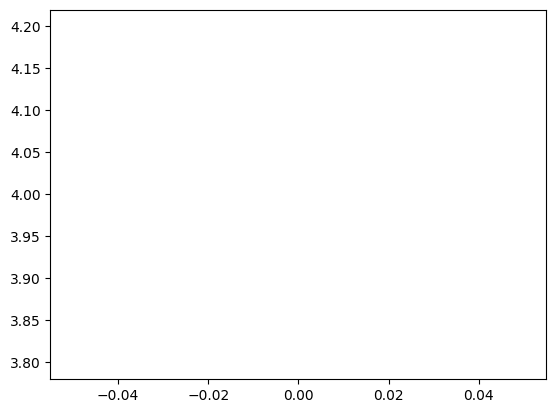

301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256
262
269
176
184
192
201
210
220
230
241
252
264
206
176
167
158
150
142
135
268
237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603


237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263
256
250
244
239
234
230
226
223
220
218
216
215
214
214
214
215
216
218
220
223
226
230
234
239
244
250
256
263
270
278
286
295
304
314
344
314
378
348
398
368
418
429
439
409
459
469
479
490
500
470
460
452
443
436
428
422
415
410
404
400
395
392
388
386
383
606
576
567
558
550
652
663
673
683
693
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188


265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263
256
250
244
239
234
230
226
223
220
218
216
215
214
214
214
215
216
218
220
223
226
230
234
239
244
250
256
263
270
278
286
295
304
314
344
314
300
270
261
252
244
236
229
362
331
322
313
305
297
290
283
277
271
266
261
452
421
412
403
395
387
380
513
523
533
503
494
485
571
582
592
562
552
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269


343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256
262
269
176
184
192
201
210
220
230
241
252
264
206
176
167
158
150
142
135
268
237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263


172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263
256
250
244
239
234
230
226
223
220
218
216
215
214
214
214
215
216
218
220
223
226
230
234
239
244
250
256
263
270
278
286
295
304
314
344
314
337
348
358
368
338
329
320
406
416
386
377
368
360
352
470
440
431
422
508
478
469
460
452
444
437
430
424
418
413
408
404
400
397
394
392
390
389
388
388
388
389
390
392
394
397
400
404
408
413
418
424
430
437
444
452
460
469
478
488
498
509
520
532
544
557
570
584
598
613
628
644
660
677
330
299
290
281


171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256
262
269
176
184
192
201
210
220
230
241
252
264
206
176
167
158
150
142
135
268
237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
408
405
401
399
396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263
256
250
244
239
234
230
226
223
220
218
216
215
214
214
214
215
216
218


396
395
393
393
392
393
393
395
396
399
401
405
408
413
417
423
428
435
441
449
456
465
473
483
492
503
513
525
536
549
561
575
588
603
617
633
648
665
681
334
304
295
286
278
270
263
256
250
244
239
234
230
226
223
220
218
216
215
214
214
214
215
216
218
220
223
226
230
234
239
244
250
256
263
270
278
286
295
304
314
344
314
317
287
278
269
261
253
371
341
332
323
315
307
300
293
287
281
276
271
267
466
435
426
417
409
401
394
387
381
375
370
365
361
357
354
351
349
347
346
345
345
345
346
347
349
351
354
357
361
365
370
375
381
387
394
401
409
417
426
435
445
455
466
477
489
501
514
527
541
555
570
585
601
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256


307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156
150
143
138
132
128
123
120
116
114
111
110
108
108
107
108
108
110
111
114
116
120
123
128
132
138
143
302
272
263
254
340
310
301
292
284
276
269
262
256
250
245
240
236
232
229
226
224
222
221
220
220
220
221
222
224
226
229
232
236
240
245
250
256
262
269
176
184
192
201
210
220
230
241
252
264
206
176
167
158
150
142
135
268
237
228
219
211
203
196
189
183
177
172
167
163
159
156
153
151
149
148
147
147
147
148
149
151
153
156
159
163
167
172
177
183
189
196
203
322
291
282
273
265
257
250
243
237
231
226
221
217
213
210
207
205
203
202
201
201
201
202
203
205
207
210
213
217
221
226
231
237
243
250
257
265
273
282
291
301
332
342
312
362
332
382
492
503
513
483
473
465
456
449
441
435
428
423
417
413
603
573
563
555
546
649
619
610
601
301
302
303
305
307
310
313
317
321
326
331
337
343
350
357
365
373
382
391
401
411
422
190
160
150
142
228
198
188
180
171
164
156


KeyboardInterrupt: 

In [381]:
import matplotlib.pyplot as plt

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)
l=[]
#defining timer for the obstacles to occur
for i in range(10000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,980)

    #bird=pg.transform.rotate(bird,-30)
    obs_list=[[500,400],[900,300],[1300,400]]
    obst_list=[[500,400-680],[900,300-680],[1300,400-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    cur_st[2]=0
    smax=0
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                x=4*random.randint(300,330)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[3]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=561 or el1.top<=5:
            reward=-300
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward-Y*Q_value[tuple(cur_st_en)])
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=10
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()

        t=t+0.5
        cur_st=[next_state[0],next_state[1],next_state[2]]
        print(next_state[1])
        pg.display.update()
        clock.tick(120)
    l.append(smax)
    #print(i)
    if i%100==0:
        plt.plot(np.arange(i+1),l)
        plt.show()
    

In [391]:
eps=eps=0.000001

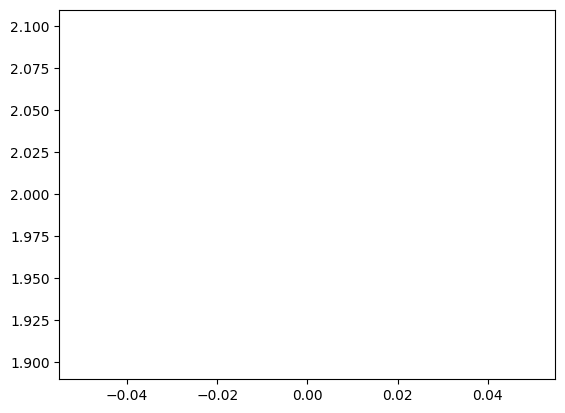

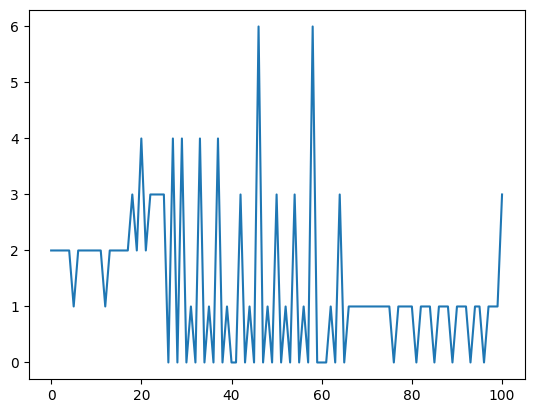

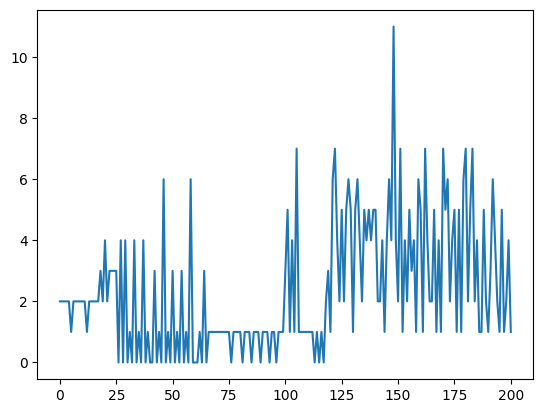

KeyboardInterrupt: 

In [397]:
import matplotlib.pyplot as plt

pg.init()
screen=pg.display.set_mode((1200,576))
pg.display.set_caption("Hello")
clock=pg.time.Clock()
font = pg.font.Font('freesansbold.ttf', 22)
sky=pg.image.load('game_dev/finalbg.jpg').convert()
pipe=pg.image.load('game_dev/pipe.png').convert_alpha()
pipe=pg.transform.scale(pipe,(100,500))
pipet=pg.transform.rotate(pipe,180)
pipet=pg.transform.flip(pipet,True,False)
pipet_rect=pipet.get_rect(topleft=(1200,-50))
pipe_rect=pipe.get_rect(topleft=(1200,300))
pipe_rect_copy=pipe.get_rect(topleft=(550,300))
pipet_rect_copy=pipet.get_rect(topleft=(550,-50))
bird=pg.image.load('game_dev/bird.png').convert_alpha()
bird=pg.transform.scale(bird,(70,50))
bird_rect=bird.get_rect(center=(100,100))
sbt=font.render("START",True,"red")
sbt_rect=sbt.get_rect(center=(600,288))
screen.blit(sbt,sbt_rect)
l=[]
#defining timer for the obstacles to occur
for i in range(1000000):
    bird_rect=bird.get_rect(center=(100,400))
    timer=pg.USEREVENT+1
    pg.time.set_timer(timer,980)

    #bird=pg.transform.rotate(bird,-30)
    random.seed(1)
    y1=400+random.randint(-50,50)
    random.seed(2)
    y2=300+random.randint(-50,50)
    random.seed(3)
    y3=350+random.randint(-50,50)
    obs_list=[[500,y1],[900,y2],[1300,y3]]
    obst_list=[[500,y1-680],[900,y2-680],[1300,y3-680]]
    t=0
    a=0
    score="0"
    s=bird_rect.centery
    text = font.render(score, True, (77,208,225))
    text_rect = text.get_rect(center=(600,80))
    el=pg.draw.circle(screen,"blue",bird_rect.center,20)
    done=False
    cur_st=[0,0,0]
    cur_st[0]=(obs_list[0][0]-100)/4
    cur_st[1]=obs_list[0][1]-bird_rect.centery+301
    cur_st[2]=0
    smax=0
    while not done:
        #draw everything and update
        for event in pg.event.get():
            if event.type==pg.QUIT:
                print(l)
                pg.quit()
                sys.exit()
            #if event.type==pg.KEYDOWN:
                #s=s+t*t-t*a
                #a=21
                #t=0.5
            if event.type==timer:
                random.seed(4)
                x=4*random.randint(300,330)
                random.seed(5)
                y=400+random.randint(-150,100)
                obs_list.append([x,y])
                obst_list.append([x,y-680])
        # defining thr rectangle postions
        el=pg.draw.circle(screen,"blue",bird_rect.center,20)
        
        #S
        
        screen.blit(sky,(-100,0))
        bird_rect.centery=s+t*t-t*a
        v=a-t*2
        screen.blit(bird,bird_rect)
        screen.blit(text,text_rect)

        obs_list,obst_list=obstacle_render(obs_list,obst_list)
        cur_st_en=create_tile_encoding(cur_st)
        #A
        if random.uniform(0,1)<eps:
            action=random.randint(0,1)
        else:
            action=np.argmax(Q_value[tuple(cur_st_en)])
        cur_st.append(action)
        cur_st_en.append(action)
        
        #S'
        next_state=get_next_state(cur_st,obs_list)
        next_state_en=create_tile_encoding(next_state)
        # in one time stamp x reduces by one and y by an amout specified by an equation of motion
        # so in order to find the subsequent states i would need to do a lookahead in the s using a hypothetical 
        # jump or no jump and then check the max of q values of both states and decide greedly....

        
        
        if cur_st[3]==0:
            ys=s+(t+0.5)*(t+0.5)-(t+0.5)*a
        else:
            ys=s+t*t-t*a + 0.5*0.5 -0.5*21
        el1=pg.draw.circle(screen,"blue",(104,ys),20)
        if  el1.colliderect(pipe.get_rect(topright=obs_list[0])) or el1.colliderect(pipet.get_rect(topright=obst_list[0])) or el1.bottom>=561 or el1.top<=5:
            reward=-300
            done=True
            Q_value[tuple(cur_st_en)]+=td_error*(reward-Y*Q_value[tuple(cur_st_en)])
        else:
            if random.uniform(0,1)<eps:
                action_next=random.randint(0,1)
            else:
                action_next=np.argmax(Q_value[tuple(next_state_en)])
            next_state.append(action_next)
            next_state_en.append(action_next)
            reward=0.5
            if next_state[0]==0:
                reward=10
            Q_value[tuple(cur_st_en)]+=td_error*(reward + Y*(Q_value[tuple(next_state_en)]-Q_value[tuple(cur_st_en)]))

        if action==1:
            s=s+t*t-t*a
            t=0
            a=21

        if obs_list and el.right==obs_list[0][0]+16:
            score=str(eval(score)+1)
            smax=max(0,eval(score))
            text = font.render(score, True,(77,208,225))
        #if (obs_list and obst_list and (el.colliderect(pipe.get_rect(topleft=obs_list[0])) or el.colliderect(pipet.get_rect(topleft=obst_list[0])))) or bird_rect.bottom>=576 or bird_rect.top<=0:
            #pg.quit()
            #sys.exit()

        t=t+0.5
        cur_st=[next_state[0],next_state[1],next_state[2]]
        #print(next_state[1])
        pg.display.update()
        clock.tick(120)
    l.append(smax)
    #print(i)
    if i%100==0:
        plt.plot(np.arange(i+1),l)
        plt.show()
    if i%1000==0 and i!=0:
        eps=eps/10
        td_error/=10
    

In [399]:
Q_value

array([[[[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        ...,

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.       

In [400]:
np.save("data_file.npy", Q_value)

# Saving to a text file (.txt or .csv)
np.savetxt("data_file.txt", Q_value.flatten())

In [405]:
# reload Q_value
# Loading from a binary file (.npy)
loaded_data = np.load("data_file.npy")

#or 

# Loading from a text file (.txt or .csv)
#loaded_data = np.loadtxt("data_file.txt")


In [406]:
print(loaded_data==Q_value)

[[[[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  ...

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]]


 [[[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]
   ...
   [ True  True]
   [ True  True]
   [ True  

In [407]:
loaded_data

array([[[[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ]],

        ...,

        [[   0.        ,    0.        ],
         [   0.        ,    0.        ],
         [   0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ],
         [   0.       